## Introduction

In [1]:
import os
import IPython.display as ipd
import librosa
from glob import glob
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import pyloudnorm as pyln
from scipy import signal, linalg
import sklearn
from ipywidgets import interact
import urllib
import mir_eval

import torch
from pprint import pprint
from pyannote.audio import Pipeline

from sklearn import preprocessing
from sklearn import cluster
%matplotlib inline

/home/sofiiafolv/.local/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [5]:
# # Uncomment it to download
# !kaggle datasets download -d mfekadu/english-multispeaker-corpus-for-voice-cloning
# !unzip english-multispeaker-corpus-for-voice-cloning.zip -d ../../data/

In [5]:
wave_pathes = glob(
    "../../data/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True
)
# In case of Windows
wave_pathes = [wave_path.replace('\\', '/') for wave_path in wave_pathes]
sample_file = wave_pathes[0]
ipd.Audio(sample_file)

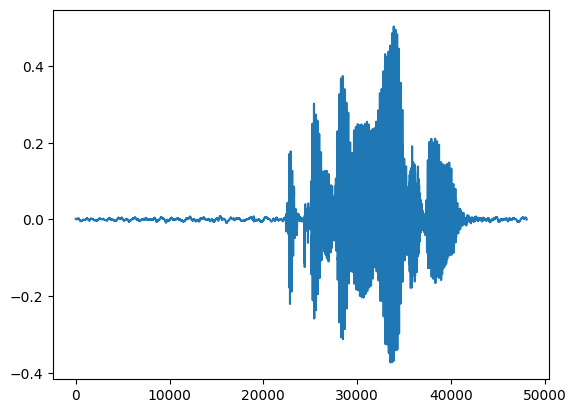

In [7]:
sample_audio, sample_audio_sr = librosa.load(sample_file)
sample_audio_sr
plt.plot(sample_audio)

In [8]:
violin_audio_filename = "T08-violin.wav"
urllib.request.urlretrieve(f"https://ccrma.stanford.edu/workshops/mir2014/audio/{violin_audio_filename}", filename=violin_audio_filename)
ipd.Audio("T08-violin.wav")

## Pre-processing

### Normalization


#### Loudness
Loudness measurement has evolved with the introduction of **LUFS**, an acronym for **Loudness Units relative to Full Scale** or simply **Loudness Units Full Scale**. This metric represents the peak capability of a system and integrates both the human auditory system's perception and the electrical intensity of the sound signal. Essentially, LUFS offer a contemporary and accurate method for gauging audio loudness, aiming for uniform sound levels across various media.

Loudness can be assessed through two primary methods: Peak and RMS (root mean square). The Peak method identifies the maximum audio level, whereas RMS calculates the sound's average intensity. While some audio mastering professionals may normalize tracks in an album to the same peak level, this approach can result in tracks with inherently higher volumes sounding disproportionately loud. On the other hand, relying solely on RMS might lead to tracks peaking above 0, potentially causing distortion. This is where LUFS come into play.

LUFS values are typically represented as negative numbers, such as -6 LUFS, -11 LUFS, or -16 LUFS, indicating the loudness level relative to the system's maximum capacity. A value closer to 0 indicates greater loudness, whereas values further from 0 denote quieter sounds. LUFS thus provide a balanced and standardized approach to measuring and normalizing audio loudness, ensuring consistency across various listening platforms.







#### Peak normalization
Peak normalization involves adjusting an audio signal so that its maximum amplitude aligns with the loudest part of the waveform. Imagine a scenario where the most prominent sound in an audio clip is a vocal segment where the person is shouting. If this shout is measured at -6 LUFS, peak normalization aims to enhance this specific segment until it hits the 0 LUFS mark. This process involves calculating the difference between the shout's present volume and the highest possible volume it can achieve without causing distortion. The goal is to ensure that the peak loudness of the shout reaches the absolute maximum allowed level, thereby maximizing the overall loudness of the audio without compromising quality.



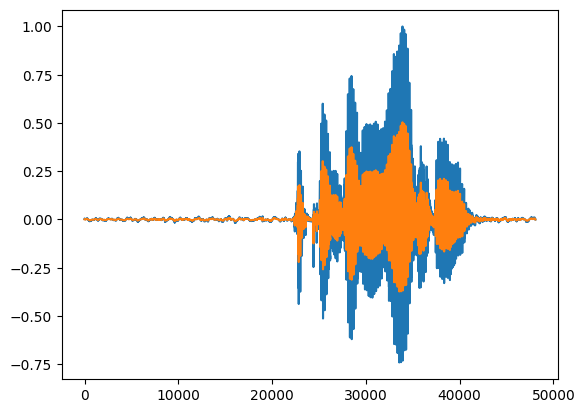

In [9]:
# Perform peak normalization
peak_normalized_audio = sample_audio / np.max(np.abs(sample_audio))
plt.plot(peak_normalized_audio)
plt.plot(sample_audio)

In [10]:
sf.write("temp.wav", data=peak_normalized_audio, samplerate=sample_audio_sr)
ipd.Audio("temp.wav")

#### Loudness Normalization
Loudness normalization involves adjusting the gain so that the average volume of the audio reaches a specified target level.

<!--
One of the reasons why it is important for digital streaming services like Spotify and Apple Music, audio normalization has become an essential part of the process -->

Audio normalization has become an essential part of the preprocessing for for digital streaming services like Spotify and Apple Music.

Music streaming platforms establish a uniform loudness level for the tracks in their libraries, ensuring users don't need to frequently adjust the volume when moving between songs. Each service adopts its own target loudness level, leading to the necessity for distinct masters tailored to each platform's specifications.

The following are the loudness targets set by some of the most widely used streaming services, measured in LUFS (Loudness Units relative to Full Scale):

* Spotify: -14 LUFS
* Apple Music: -16 LUFS
* Amazon Music: ranges from -9 to -13 LUFS
* YouTube: spans from -13 to -15 LUFS
* Deezer: varies between -14 and -16 LUFS
* CDs are typically mastered to -9 LUFS
* SoundCloud: varies from -8 to -13 LUFS

Audio engineers might have different approaches in deciding the precise loudness for each master. However, it's crucial to consider these loudness standards during the mastering process to ensure optimal playback across various platforms.

In [11]:
# measure the loudness first
meter = pyln.Meter(sample_audio_sr) # create BS.1770 meter
loudness = meter.integrated_loudness(sample_audio)
loudness

-23.335912865599678

In [12]:
# loudness normalize audio to -12 dB LUFS
loudness_normalized_audio = pyln.normalize.loudness(sample_audio, loudness, -12.0)
sf.write("temp.wav", data=loudness_normalized_audio, samplerate=sample_audio_sr)
ipd.Audio("temp.wav")

### Audiomentations

Audiomentations, a powerful library for audio data augmentation in Python. This can be particularly useful for machine learning and deep learning applications, where augmented data can help improve model robustness and performance.

> **TODO**: Why do we need augmentation in the modern Deep Learning era? Where can we use them? (propose as many applications, as possible)


In [13]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
])

augmented_audio = augment(samples=sample_audio, sample_rate=sample_audio_sr)
plt.plot(augmented_audio)
plt.plot(sample_audio)


ModuleNotFoundError: No module named 'audiomentations'

`AddGaussianNoise` Add gaussian noise to the samples
![AddGaussianNoise](https://iver56.github.io/audiomentations/waveform_transforms/AddGaussianNoise.webp)


---



`TimeStretch` Change the speed or duration of the signal without changing the pitch. This transform employs `librosa.effects.time_stretch` under the hood to achieve the effect.
![TimeStretch](https://iver56.github.io/audiomentations/waveform_transforms/TimeStretch.webp)

`PitchShift` Pitch shift the sound up or down without changing the tempo.

Under the hood this does time stretching (by phase vocoding) followed by resampling. Note that phase vocoding can degrade audio quality by "smearing" transient sounds, altering the timbre of harmonic sounds, and distorting pitch modulations. This may result in a loss of sharpness, clarity, or naturalness in the transformed audio.

![PitchShift](https://iver56.github.io/audiomentations/waveform_transforms/PitchShift.webp)

## Audio Filtering

The word "filter” denotes the removal of undesirable elements. Water filters serve as the best illustrations of filters. Why is it utilized? Impurities are taken out of the water using it. The electric filter functions similarly to a water filter.

Amplifiers, inductors, capacitors, and resistors are components of the electric filter. The electric filter is used to attenuate signals that are lower or higher in frequency while allowing signals at a specific level of frequency to flow through.

Cut-off frequency refers to the frequency at which a filter operates. The filter's cut-off frequency is chosen during filter design.

Electronic filters that allow signals with frequencies higher than a given cutoff frequency and suppress signals with frequencies lower than that cutoff frequency are referred to as high pass filters. They are also referred to as low-cut filters or bass-cut filters.

### Low-pass and High-pass Filters

In [ ]:
# Signal definition
t_duration = np.linspace(0, 0.5, 2000, False)
sign = np.sin(2 * np.pi * 100 * t_duration)# + np.sin(2 * np.pi * 10 * t_duration)
fig, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(t_duration, sign)
ax1.set_title('10 and 100 Hz Sinusoid')
ax1.axis([0, 0.5, -2, 2.5])

In [ ]:
# Play with dtype = "high" or "low"
dtype = "low"
sos = signal.butter(6, 30, dtype, fs=2000, output="sos")
filtd = signal.sosfilt(sos, sign)
fig, (ax2) = plt.subplots(1, 1, sharex=True)
ax2.plot(t_duration, filtd)
ax2.set_title(f"After applying 20 Hz {dtype}-pass filter")
ax2.axis([0, 0.5, -2, 2.5])
ax2.set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

#### How does this work from scratch?
The basic idea is to take the Fourier transform of your signal, apply the Butterworth filter in the frequency domain by multiplying the Fourier transform of the signal by the Fourier transform of the Butterworth filter, and then take the inverse Fourier transform to get back to the time domain. This approach is suitable for applications where linear phase characteristics are important.

The Butterworth filter's magnitude response in the frequency domain can be given by:

$H(f)= \dfrac{1}{1 + \left( \frac{f}{f_c} \right)^{2n}}$


$H(f)$ is the filter's frequency response.

$f$ is the frequency.

$f_c$ is the cutoff frequency.

$n$ is the order of the filter.

If you want implement this from scratch:

**Design the Butterworth Filter Frequency Response**: Calculate the frequency response of the Butterworth filter based on the desired cutoff frequency and filter order.

**Apply the Filter in the Frequency Domain**: Multiply the Fourier transform of the signal by the frequency response of the Butterworth filter.

**Transform Back to the Time Domain**: Use the inverse Fourier transform to convert the filtered signal back to the time domain.

> <font color='red'>**TODO**</font>: Implement Butterworth Filter from scratch.


### Band-pass Filtering

Bandpass filters integrate the functions of both high-pass and low-pass filters, allowing only frequencies within a specific range to be transmitted.

In [ ]:
t_duration = np.linspace(0, 0.5, 2000, False)
sign = np.sin(2 * np.pi * 10 * t_duration) + np.sin(2 * np.pi * 100 * t_duration)
fig, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(t_duration, sign)
ax1.set_title("10 and 100 Hz Sinusoid")
ax1.axis([0, 0.5, -2, 2.5])
sos = signal.butter(6, [5, 25], "bp", fs=2000, output='sos')
filtd = signal.sosfilt(sos, sign)
fig, (ax2) = plt.subplots(1, 1, sharex=True)
ax2.plot(t_duration, filtd)
ax2.set_title("After applying 5-30 Hz band-pass filter")
ax2.axis([0, 0.5, -2, 2.5])
ax2.set_xlabel("Time (seconds)")
plt.tight_layout()
plt.show()

### Filter Classes
The class of a filter influences various characteristics, including the presence of ripples within the passbands or stopbands and the steepness of the transition from passband to stopband. It's important to note that a filter's category is distinct from its order or cutoff frequency.

Several well-known filter categories are as follows:

* **Butterworth**: Known for achieving the sharpest decline without causing ripples in the passband or stopband.
* **Chebyshev**: Offers a sharper decline compared to Butterworth filters, but this comes with the trade-off of ripple in either the passband or stopband, depending on its design.
* **Elliptic**: Provides an even sharper decline than Chebyshev filters, but at the expense of ripples in both the passband and stopband.
* **Bessel**: Characterized by a gentle decline, but maintains a linear phase response and consistent group delay in the passband, which is crucial for some specific applications.

In [ ]:
plt.figure(figsize=(12, 12))

# Butterworth
b, a = signal.butter(3, 1000 * 2 * np.pi, btype="lowpass", analog=True)
angularFreq, freqResponse, phaseResponse = signal.bode(signal.lti(b, a))

plt.subplot(2, 2, 1)
plt.semilogx(angularFreq, freqResponse)
plt.title("Butterworth Frequency Response")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.ylabel("Phase (Degrees)")

# Chebyshev
b, a = signal.cheby1(3, 3, 1000 * 2 * np.pi, btype="lowpass", analog=True)
angularFreq, freqResponse, phaseResponse = signal.bode(signal.lti(b, a))

plt.subplot(2, 2, 2)
plt.semilogx(angularFreq, freqResponse)
plt.title("Chebyshev Frequency Response")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")

plt.show()

### Order

A first-order filter represents the most basic form of a specific filter class, utilizing the minimum number of components (or computational steps in a digital context), but also delivering the least effective performance in terms of factors such as ripple or the rate of transition from passband to stopband.

Increasing the order of the filter requires additional components or computational efforts, yet it results in a more pronounced rolloff. This effect can be observed by adjusting the filter order in the provided interactive example below.






In [ ]:
@interact(cutoff=(0.005, 9.9, 1), band_type=["lowpass", "highpass"], filter_class=["butterworth", "chebyshev1", "chebyshev2", "elliptic", "bessel"], order=(1, 10, 1))
def filter_buffer(cutoff, band_type, filter_class, order):
    # Build our sine signal
    NUM_SAMPLES = 200
    SAMPLE_RATE = 44100
    sampleRange = np.linspace(0, 4 * np.pi, NUM_SAMPLES)
    buffer = np.sin(sampleRange) + np.sin(5 * sampleRange) + np.sin(20 * sampleRange)

    plt.figure(figsize=(15, 3))

    # Plot the input signal
    plt.subplot(1, 3, 1)
    plt.plot(sampleRange, buffer)
    plt.ylim(bottom=-3, top=3)
    plt.title("Filter Input")
    plt.xlabel("Samples")
    plt.ylabel("Displacement")

    # Calculate the coefficients of a Butterworth filter for the given cutoff
    # and apply the filtering
    if filter_class == "butterworth":
        b, a = signal.butter(order, cutoff / 10.0, btype=band_type, analog=False)
    elif filter_class == "chebyshev1":
        b, a = signal.cheby1(order, 0.5, cutoff / 10.0, btype=band_type, analog=False)
    elif filter_class == "chebyshev2":
        b, a = signal.cheby2(order, 20, cutoff / 10.0, btype=band_type, analog=False)
    elif filter_class == "elliptic":
        b, a = signal.ellip(order, 0.5, 20, cutoff / 10.0, btype=band_type, analog=False)
    elif filter_class == "bessel":
        b, a = signal.bessel(order, cutoff / 10.0, btype=band_type, analog=False)

    buffer = signal.lfilter(b, a, buffer)

    # Calculate our frequency response
    angularFreq, response = signal.freqz(b, a, worN=8000)

    # Plot output and frequency response
    plt.subplot(1, 3, 2)
    plt.plot(0.5 * SAMPLE_RATE * angularFreq / np.pi, np.abs(response))
    plt.xlim(0, 0.5 * SAMPLE_RATE)
    plt.title("Filter Frequency Response")
    plt.xlabel("Frequency (Hz)")

    plt.subplot(1, 3, 3)
    plt.plot(sampleRange, buffer)
    plt.ylim(bottom=-3, top=3)
    plt.title("Filter Output")
    plt.xlabel("Samples")
    plt.ylabel("Displacement")

    plt.show()

### Wiener filter
The Wiener filter is a statistical filter used for signal processing, specifically designed to reduce the noise present in a signal. It is based on a statistical approach, aiming to minimize the mean square error between the estimated and the true signal. The Wiener filter is particularly effective when the signal and noise characteristics (spectral properties) are known or can be estimated.



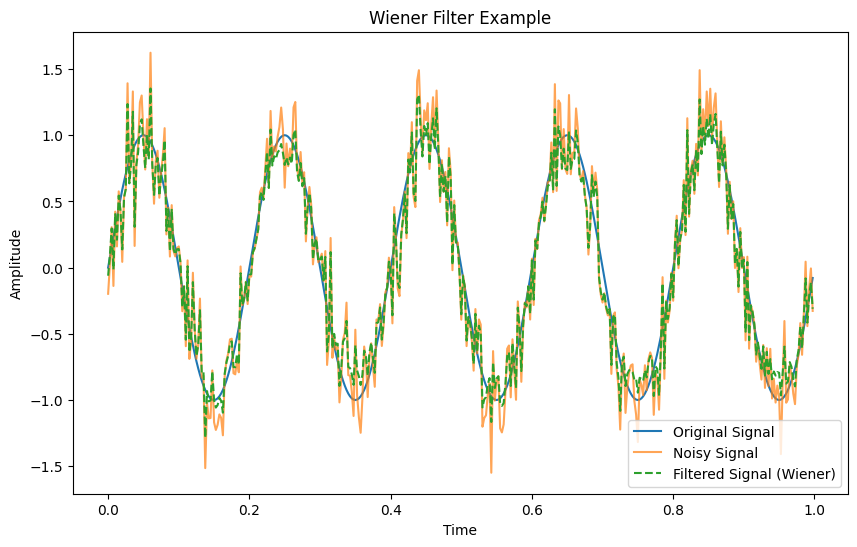

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener

# Create a sample signal (e.g., a sine wave)
t = np.linspace(0, 1, 400, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t)

# Add Gaussian noise to the signal
noise_variance = 0.05
noisy_signal = signal + np.random.normal(0, np.sqrt(noise_variance), signal.shape)

# Apply the Wiener filter
filtered_signal = wiener(noisy_signal, mysize=29, noise=noise_variance)

# Plot the original, noisy, and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
plt.plot(t, filtered_signal, label='Filtered Signal (Wiener)', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Wiener Filter Example')
plt.show()

## Clustering
The are many clustering algorithms, but we will discuss K-means, as one of the most known.

The procedure of K-means is straightforward:

1. Start by initializing all k centroids.
1. Repeat steps 3 and 4 for a predefined number of iterations.
1. Assign each data point to the nearest centroid.
1. Update the centroids by calculating the average of all data points that share the same label.

> **TODO**: What are good stop criteria for K-means? (explore `sklearn`)

### Example 1 (Onset clustering)

In [33]:
violin_audio_filename = "T08-violin.wav"
ipd.Audio(violin_audio_filename)

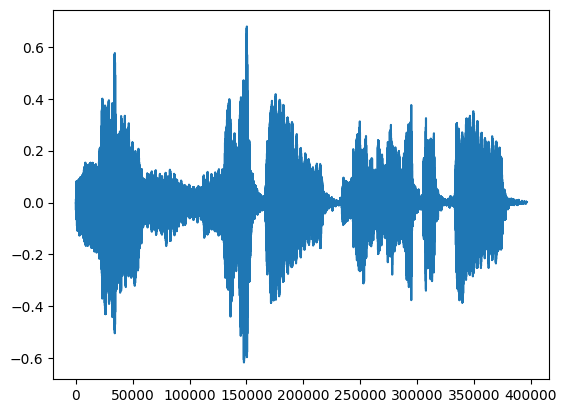

In [34]:
violin_audio, violin_audio_sr = librosa.load(violin_audio_filename)
plt.plot(violin_audio)

#### Onset detection

In [35]:
onset_frames = librosa.onset.onset_detect(y=violin_audio, sr=violin_audio_sr, delta=0.04, wait=4)
onset_times = librosa.frames_to_time(onset_frames, sr=violin_audio_sr)
onset_samples = librosa.frames_to_samples(onset_frames)

In [37]:
audio_with_beeps = mir_eval.sonify.clicks(onset_times, violin_audio_sr, length=len(violin_audio))
ipd.Audio(violin_audio + audio_with_beeps, rate=violin_audio_sr)

#### Feature extraction & scaling

In [40]:
def extract_features(x, fs):
    zcr = librosa.zero_crossings(x).sum()
    energy = linalg.norm(x)
    return [zcr, energy]

frame_sz = int(violin_audio_sr * 0.090)
features = np.array([extract_features(violin_audio[i:i+frame_sz], violin_audio_sr) for i in onset_samples])
print(features.shape)

(50, 2)
22050


Text(0, 0.5, 'Spectral Centroid (scaled)')

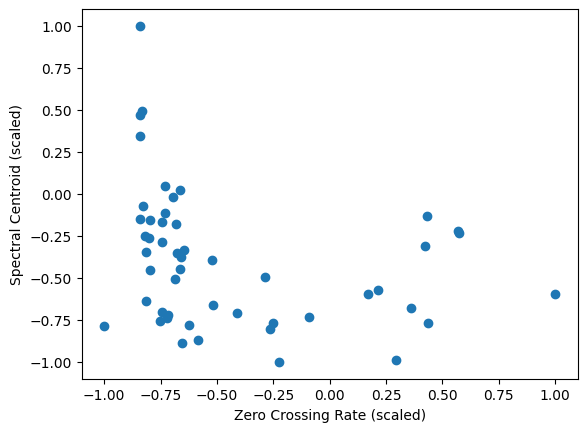

In [39]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
plt.scatter(features_scaled[:,0], features_scaled[:,1])
plt.xlabel("Zero Crossing Rate (scaled)")
plt.ylabel("Spectral Centroid (scaled)")

#### Clustering

In [ ]:
model = sklearn.cluster.KMeans(n_clusters=2)
labels = model.fit_predict(features_scaled)
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))

In [ ]:
audio_with_beeps = mir_eval.sonify.clicks(onset_times[labels==0], violin_audio_sr, length=len(violin_audio))
ipd.Audio(violin_audio + audio_with_beeps, rate=violin_audio_sr)

In [ ]:
audio_with_beeps = mir_eval.sonify.clicks(onset_times[labels==1], violin_audio_sr, length=len(violin_audio))
ipd.Audio(violin_audio + audio_with_beeps, rate=violin_audio_sr)

### Example 2 (Speaker Diarization)

Speaker diarization is an audio processing technique that distinguishes and separates speech segments according to the speaker. It addresses the query, "Who spoke when?" This technique is especially valuable in settings with multiple speakers, like meetings, legal hearings, or telephone conversations.

In [ ]:
filename = "../../data/VCTK-Corpus/VCTK-Corpus/wav48/p306/p306_003.wav"
audio1, sr1 = librosa.load(filename, sr=None)
print(len(audio1))
ipd.Audio(filename)

In [ ]:
filename = "../../data/VCTK-Corpus/VCTK-Corpus/wav48/p274/p274_003.wav"
audio2, sr2 = librosa.load(filename, sr=None)
print(len(audio2))
ipd.Audio(filename)

In [ ]:
sr = sr1
sr1 == sr2

In [ ]:
audio = np.concatenate((audio1[10000:20000], audio2[10000:20000]))
scaler = sklearn.preprocessing.StandardScaler()
mfccs = librosa.feature.mfcc(y=audio, sr=sr)
mfccs_scaled = scaler.fit_transform(mfccs.T)
kmeans = sklearn.cluster.KMeans(n_clusters=2)  # Adjust based on the expected number of speakers
speaker_labels = kmeans.fit_predict(mfccs_scaled)

for i, label in enumerate(speaker_labels):
    print(f"Time Segment {i}: Speaker {label}")

# Homework

Theory (5 points):
- Follow links.
- Try to fill **TODO** comments.
- Answer theory questions in the Google Form.

Practice (10 points):

- Implement [VAD](https://en.wikipedia.org/wiki/Voice_activity_detection) (Voice Activity Detection) system, using algorithms/methods from the lecture (or nearby them)
  - DO NOT USE Ready to use algorithms
  - DO NOT USE supervised algorithms
- Evaluate using DetectionErrorRate compared to Ready to use algorithm. For example
  - [Silero VAD](https://pytorch.org/hub/snakers4_silero-vad_vad/)  - Obligatory 
  - [webrtcvad](https://github.com/wiseman/py-webrtcvad) - Optional 
  - Maybe you can find something else interesting - Optional

## Homework Practice Part Baseline

In [2]:
model, utils = torch.hub.load(repo_or_dir="snakers4/silero-vad", model="silero_vad", force_reload=True)
get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/sofiiafolv/.cache/torch/hub/master.zip


In [6]:
wav = read_audio(wave_pathes[0])
ipd.Audio(wave_pathes[0])

In [7]:
speech_timestamps = get_speech_timestamps(wav, model)
pprint(speech_timestamps)

[{'end': 31200, 'start': 15904}]


In [8]:
save_audio("only_speech.wav", collect_chunks(speech_timestamps, wav))
ipd.Audio("only_speech.wav")

In [9]:
HUGGING_FACE_ACCESS_TOKEN = "<your_access_token>"
pipeline = Pipeline.from_pretrained("pyannote/voice-activity-detection",
                                    use_auth_token=HUGGING_FACE_ACCESS_TOKEN)

torchvision is not available - cannot save figures
Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.2.0+cu121. Bad things might happen unless you revert torch to 1.x.


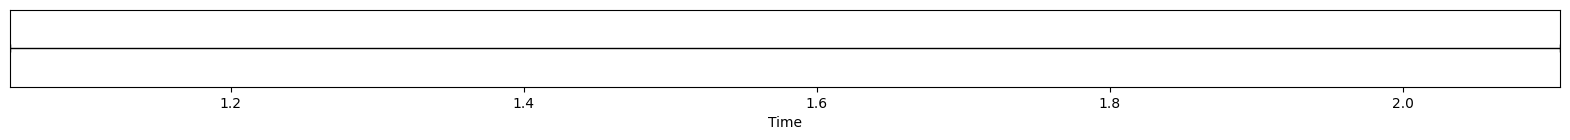

In [10]:
# The result are pretty bad, as silence in the beginning isn't detected
output = pipeline(wave_pathes[0])
output.get_timeline()

In [32]:
# How to extract labels?
[{"start": segment.start, "end": segment.end, "label": label} for segment, _, label in output.itertracks(yield_label=True)]

[{'start': 1.0494880546075085, 'end': 2.107508532423208, 'label': 'SPEECH'}]

## Metric evaluation

In [12]:
from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionErrorRate

metric = DetectionErrorRate()

for file in wave_pathes[:10]:
    wav = read_audio(file)
    speech_timestamps = get_speech_timestamps(wav, model)
    reference = Annotation()
    for speech in speech_timestamps:
      reference[Segment(speech["start"] / 10000, speech["end"] / 10000)] = "SPEECH"
    hypothesis = pipeline(file)

    # evaluate its output
    _ = metric(
        reference,      # this is the reference annotation
        hypothesis)     # this is the hypothesized annotation

# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 81.0%


## Homework. VAD Implementation

In [13]:
# imported implemented VAD from module VAD.py
from VAD import vad_algorithm

wave_pathes = glob(
    "../../data/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True
)
# In case of Windows
wave_pathes = [wave_path.replace('\\', '/') for wave_path in wave_pathes]
sample_file = wave_pathes[0]
sample_audio, sample_audio_sr = librosa.load(sample_file)


[{'start': 18744, 'end': 18810}, {'start': 18854, 'end': 18876}, {'start': 18898, 'end': 20262}, {'start': 20306, 'end': 20482}, {'start': 20504, 'end': 20526}, {'start': 20548, 'end': 20592}, {'start': 20680, 'end': 20746}, {'start': 20768, 'end': 20878}, {'start': 21208, 'end': 21230}, {'start': 21296, 'end': 21340}, {'start': 21362, 'end': 21406}, {'start': 21472, 'end': 21516}, {'start': 21538, 'end': 21648}, {'start': 21670, 'end': 21736}, {'start': 21846, 'end': 21868}, {'start': 22000, 'end': 22044}, {'start': 22088, 'end': 32450}, {'start': 32494, 'end': 32692}, {'start': 32714, 'end': 32868}, {'start': 32934, 'end': 32956}, {'start': 32978, 'end': 33000}, {'start': 35024, 'end': 35398}, {'start': 35442, 'end': 35464}, {'start': 38390, 'end': 38456}, {'start': 38478, 'end': 38500}, {'start': 38544, 'end': 38566}]


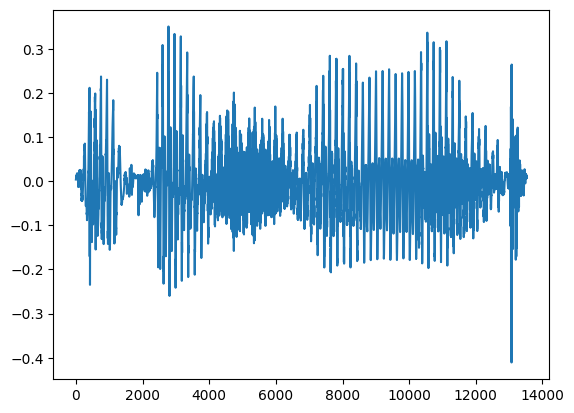

In [19]:
# example of usage
speech_timestamps = (vad_algorithm(sample_audio, sample_audio_sr, energy_threshold=0.1, frame_duration=0.001))
print(speech_timestamps)

audio = sample_audio[speech_timestamps[0]["start"] : speech_timestamps[0]["end"]]

for i in range (1, len(speech_timestamps)):
    audio = np.concatenate((audio, sample_audio[speech_timestamps[i]["start"] : speech_timestamps[i]["end"]]))
plt.plot(audio)
sf.write("speech_only.wav", data=audio, samplerate=sample_audio_sr)
ipd.Audio("speech_only.wav")

In [20]:
from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionErrorRate

metric = DetectionErrorRate()

for file in wave_pathes[:10]:
    sample_audio, sample_audio_sr = librosa.load(file)
    speech_timestamps = vad_algorithm(sample_audio, sample_audio_sr, energy_threshold=0.1, frame_duration=0.001)
    reference = Annotation()
    for speech in speech_timestamps:
      reference[Segment(speech["start"] / sample_audio_sr, speech["end"] / sample_audio_sr)] = "SPEECH"
    hypothesis = pipeline(file)

    # evaluate its output
    _ = metric(
        reference,      # this is the reference annotation
        hypothesis)     # this is the hypothesized annotation

# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

Detection error rate = 39.0%
